### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [5]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [6]:
print(data)

                                                  author  day            id  \
0      [{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...    1  1802.00209v1   
1      [{'name': 'Ji Young Lee'}, {'name': 'Franck De...   12  1603.03827v1   
2      [{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...    2  1606.00776v2   
3      [{'name': 'Sebastian Ruder'}, {'name': 'Joachi...   23  1705.08142v2   
4      [{'name': 'Iulian V. Serban'}, {'name': 'Chinn...    7  1709.02349v2   
...                                                  ...  ...           ...   
40995  [{'name': 'Vitaly Feldman'}, {'name': 'Pravesh...   18   1404.4702v2   
40996  [{'name': 'Orly Avner'}, {'name': 'Shie Mannor'}]   22   1404.5421v1   
40997  [{'name': 'Ran Zhao'}, {'name': 'Deanna Needel...   22   1404.5899v1   
40998  [{'name': 'Zongyan Huang'}, {'name': 'Matthew ...   25   1404.6369v1   
40999  [{'name': 'Imen Trabelsi'}, {'name': 'Dorra Be...   27   1407.0380v1   

                                                   

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [7]:
print(lines[0])

 Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-



In [8]:
# get all unique characters from lines (including capital letters and symbols)
tokens = list(set([char for line in lines for char in line]))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [9]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {}
for i, token in enumerate(tokens):
  token_to_id[token] = i

In [10]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`.

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [11]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [12]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
torch.set_default_device(device)

In [14]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        padding = 0 #По условию, так как паддинг применяется через слой ZeroPad2d.
        filter_size = 5 #Размер окна.
        """
        Эти параметры заданы таким образом, чтобы при условии padding = 0 и неизвестной длине sequence слой Conv1d возвращал такую же длину sequence.
        """
        strides = 1
        kernel_size = 1
        NUM_LEADING_ZEROS = strides*(filter_size-1)
        self.emb = nn.Embedding(num_embeddings = n_tokens, embedding_dim = emb_size)
        self.pad = nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
        self.conv = nn.Conv1d(in_channels = emb_size+NUM_LEADING_ZEROS, out_channels = hid_size, kernel_size = kernel_size, stride = strides, padding = padding)
        self.lin = nn.Linear(in_features = hid_size, out_features = n_tokens)


    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above
        #print("batch_size:", input_ix.shape[0])
        #print("sequence_length:", input_ix.shape[1])
        output = self.emb(input_ix)
        #print("emb:", output.shape)
        output = self.pad(output)
        #print("emb+pad:", output.shape)
        output = output.permute(0, 2, 1)
        #print("emb+pad+permute:", output.shape)
        output = self.conv(output)
        #print("emb+pad+permute+conv:", output.shape)
        output = output.permute(0, 2, 1)
        #print("emb+pad+permute+conv+permute:", output.shape)
        output = self.lin(output)
        #print("emb+pad+permute+conv+permute+lin:", output.shape)
        return output # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device = torch_device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [15]:
dummy_model = FixedWindowLanguageModel().to(torch_device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines), device = torch_device)
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'lin.weight', 'lin.bias')


In [16]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [17]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]), device = torch_device)
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [19]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.cpu().numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [20]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64, device = torch_device)
    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    mask = compute_mask(reference_answers)
    targets_1hot = F.one_hot(reference_answers, logits.shape[-1]).to(torch.float32)
    logprobs_seq = F.log_softmax(logits, dim = -1)
    logp_out = (logprobs_seq*targets_1hot).sum(dim=-1)
    return -1*torch.sum(logp_out*mask)/torch.sum(mask) # average loss, scalar



In [21]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [22]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [23]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel().to(torch_device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingá\+nf486ÜWôj+VQ4G]1`P&Ojn*rwCM)ρFã}=6Cbε"aΣ[?1dfIZΣ}pèωO}βσB8é^rH8ytEo>óωC~yèτOgi9<ω%+N5ωdlä


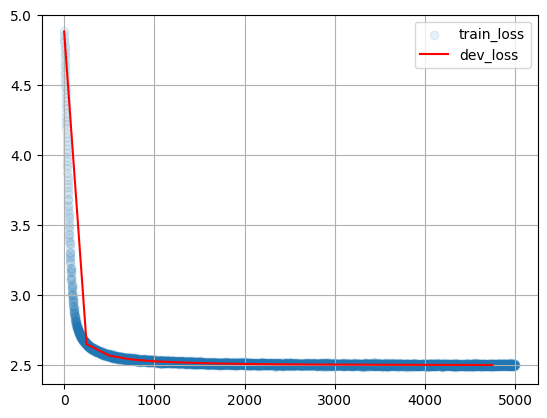

Generated examples (tau=0.5):
 wes tion oure aron de l sintis mon fontin arinting the d le t te thedionde the wa atin inin tiororer
 are of ing Con aren an aliod at tre cte catore s d thine atind wore tis titiconce anteriontintre for
 te aind the tlen ands on atinctus te acode ring the tin tie baly tis n laracathen ting tiched stal o
Scoring dev...


100%|██████████| 5000/5000 [03:28<00:00, 24.03it/s]

#4999 Dev loss: 2.503


In [24]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))


    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [25]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.5033063492658663
 te ale t n  abl at iconin tererol ouathathensed ontwinde an antrofond s f toralines iomedin al to or
 fore win r in tes min f f athevoritionges mer pr s s an on patorinthen te bess icag ling ingore s. a
 the ouctind The aroncoforang buthecat balatin ins be s e pre a ul onch an mprathe pre that malouring
 rece t are ar or thongatime ar ong alalange athe es de anale ce pre ian t Thesthent the t oncthelin 
 din f ong ured balle fon toppprne atiche is der cober thed ones athe che se mande an pre t arere The
 fon n sinton en tin urtheng win In t tand ininge thes al these tin ounins d ale acer ivends ale is a
 riled tintioshe acong e pl of on fintiol pprampranes atiorarangre thetis alen intiontreralens on tha
 te tathe actif s pons theronate Ine tis ant proronte oncon te cercorentiall antion re d the pratinss
 alerat the (Ston sting as pratinge rk tioratitet timel aralantiof The cthe ting prisinderes arisin i
 pe atererer wes chatinthowintetion iorale ce s

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [26]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.emb = nn.Embedding(num_embeddings = n_tokens, embedding_dim = emb_size)
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hid_size, batch_first = True)
        self.lin = nn.Linear(in_features = hid_size, out_features = n_tokens)

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        #print("batch_size:", input_ix.shape[0])
        #print("sequence_length:", input_ix.shape[1])
        # YOUR CODE - apply layers, see docstring above
        output = self.emb(input_ix)
        #print("emb:", output.shape)
        output = self.lstm(output)[0]
        #print("emb+lstm:", output.shape)
        output = self.lin(output)
        #print("emb+lstm_lin:", output.shape)
        return output # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device = torch_device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [27]:
model = RNNLanguageModel().to(torch_device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines), device = torch_device)
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lin.weight', 'lin.bias')


In [28]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]), device = torch_device)
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [29]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel().to(torch_device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingÉσg5E)μ{L<{á-1YZG9mνρ|ïz~Wljé^I6p"@'Σ,çôïr2o+.ΠõjHuà|{1q/á[ãíIE,K(#(ÖśïFé/óö|aμ{Böa*bIyáK7q


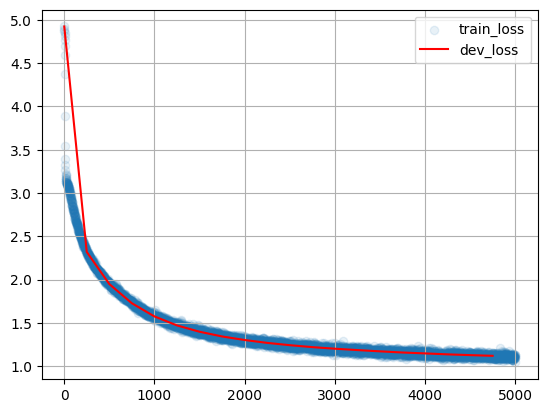

Generated examples (tau=0.5):
 Probabilistic Expressions ; In this paper we propose a set of compositional and a general method for
 Multi-view Function Recognition with Algorithms for Non-Linear Image Semantic Recognition ; In this 
 A Probabilistic Probability Search and   Convolutional Neural Networks ; Deep neural networks for th
Scoring dev...


100%|██████████| 5000/5000 [05:42<00:00, 14.61it/s]

#4999 Dev loss: 1.113


In [30]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [31]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.113199831125213
 Robustness of Adaptive Systems ; Constraints between the context of and optimization problem in the 
 Efficient Processing and Machine Learning for Neural Networks ; This paper proposes a novel approach
 A Grammar Machine Learning ; We present the problem of a computational problems of one language and 
 Discovering A Semantic Method for Generating Multi-Segmentation ; The problem of 5D prediction of th
 Fast Statistical Algorithms for Statistical Models for Image Set Algorithms ; In each the formalism 
 Control and Language for Sparse Detection ; A graph in image algorithms are an energy in the problem
 Deep Learning for Probabilistic Component Deep Networks ; The problem of a model problem of a set of
 A Learning with Adaptive Adversarial Networks ; In this paper, we show that the resulting high based
 Algorithm for Previous Policy Region for Semantic Visual Image   Betail   Multi-Trained Active Gener
 The output for a set of results ; We present a 

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize:
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [47]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)
        nucleus_probs = np.zeros(len(probs))
        while np.sum(nucleus_probs) < nucleus:
          max_prob = 0.0
          for prob in probs:
            if prob <= 0.0:
              continue
            if prob > max_prob and prob+np.sum(nucleus_probs) < nucleus:
              max_prob = prob
            elif np.sum(nucleus_probs) == 0.0 and max_prob <= 0.0:
              max_prob = prob
          if max_prob <= 0.0:
            break
          i = np.where(probs == max_prob)[0][0]
          nucleus_probs[i] = max_prob
          probs[i] = 0.0
        nucleus_probs_sum = np.sum(nucleus_probs)
        nucleus_probs /= nucleus_probs_sum
        next_token = tokens[np.argmax(nucleus_probs)]
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len:
          break
    return prefix

In [49]:
for i in range(10):
  n = (i+1)*0.1
  print("Nucleus =", n)
  print(generate_nucleus(model, nucleus = n))

Nucleus = 0.1
 Sumar-achabataretaf a Sumpasugal-Dayile-Bilot-Dysids,,:DA::selfilusiaglizabyiz;,:Dy,,0,0,0,0,0,0,0,0
Nucleus = 0.2
 Anaticl Speedinms,:::::::::::::::::::::::::::::::::::::::::::::::::::::::::,plocel imbested-boxs,pen
Nucleus = 0.30000000000000004
 Anaticl Speedinms:-Itaratesp a Seminowis onlise-becampliestines,,:symolts,-capacts,s:solhhin macrade
Nucleus = 0.4
 Anaticl Speed Sett franch Cluates:-Anathestines:-To-cholancy-Boosedie ;,tycra Treak ;-Whick,,,ste an
Nucleus = 0.5
 A Servely-botter Diftribla Struogery-Sentinglised::D:sour anames an aptraichestivalles;s:,:sthatesti
Nucleus = 0.6000000000000001
 A Servely-botter Distally-Sentimancies:-Anatomitate Convexinatines:- Controt ;-Web sensons,,,,0 isse
Nucleus = 0.7000000000000001
 A Servely-bothoutorie onlificine:ure:::::::::::::::::::::::::::::,-an algermencals,,:solth oftatinat
Nucleus = 0.8
 A Servion onlificabie too constant fociple onlific the probact ;-Web senteledency-betwore isseesi is
Nucleus = 0.9
 A Servion o

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it.

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [50]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [105]:
def generate_beamsearch(model, prefix = BOS, beam_size = 4, length = 5):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    """
    def generate_beamseach_inner(prefix, length, probability):
      prefixes = {}
      if length < 1:
        prefixes.update({prefix: probability})
        return prefixes
      token_probs = model.get_possible_next_tokens(prefix)
      tokens, probs = zip(*token_probs.items())
      probs = np.array(probs)
      top_size = min(len(probs), beam_size)
      top_indices = probs.argpartition(-top_size, axis = None)[-top_size:]
      for index in top_indices:
          result = generate_beamseach_inner(prefix+tokens[index], length-1, probability*probs[index])
          prefixes.update(result)
      return prefixes
    prefixes_dict = generate_beamseach_inner(prefix, length, 1.0)
    return max(prefixes_dict, key = prefixes_dict.get)


In [106]:
generate_beamsearch(model, prefix=" deep ", beam_size=4)

' deep learn'

In [111]:
def get_beam_dict(prefix, beam_sizes):
  beam_dict = {}
  for beam_size in beam_sizes:
    beam_dict.update({beam_size: generate_beamsearch(model, prefix, beam_size = beam_size)})
  return beam_dict
def print_beam_dict_results(beam_sizes, initial_prefix, iterations):
  different_results_prefixes = []
  for iteration in trange(iterations):
    if not bool(total_dict):
      prefix = initial_prefix
      total_dict.update({prefix: get_beam_dict(prefix, beam_sizes)})
    temp_dict = {}
    for beam_dict in total_dict.items():
      for prefix in beam_dict[1].items():
        temp_dict.update({prefix[1]: get_beam_dict(prefix[1], beam_sizes)})
    total_dict.update(temp_dict)
    for prefix in total_dict:
      results = []
      for beam_size in total_dict[prefix]:
        result = total_dict[prefix][beam_size]
        print(prefix+" -> (beam_size = "+str(beam_size)+") -> "+result)
        if result not in results:
          results.append(result)
      print("Different results amount: "+str(len(results))+".")
      if (len(results) > 0 and prefix not in different_results_prefixes):
        different_results_prefixes.append(prefix)
  if len(different_results_prefixes) > 0:
    print("Prefixes where beam sizes "+str(beam_size)+" generate different sequences:")
    print(different_results_prefixes)
print_beam_dict_results([1, 8], " deep ", 1)
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

100%|██████████| 1/1 [06:05<00:00, 365.09s/it]

 deep  -> (beam_size = 1) ->  deep learn
 deep  -> (beam_size = 8) ->  deep learn
Different results amount: 1.
 deep learn -> (beam_size = 1) ->  deep learning a
 deep learn -> (beam_size = 8) ->  deep learning a
Different results amount: 1.
 deep learning a -> (beam_size = 1) ->  deep learning and a 
 deep learning a -> (beam_size = 8) ->  deep learning algori
Different results amount: 2.
 deep learning and a  -> (beam_size = 1) ->  deep learning and a set o
 deep learning and a  -> (beam_size = 8) ->  deep learning and a novel
Different results amount: 2.
 deep learning algori -> (beam_size = 1) ->  deep learning algorithms 
 deep learning algori -> (beam_size = 8) ->  deep learning algorithms 
Different results amount: 1.
 deep learning and a set o -> (beam_size = 1) ->  deep learning and a set of the
 deep learning and a set o -> (beam_size = 8) ->  deep learning and a set of the
Different results amount: 1.
 deep learning and a novel -> (beam_size = 1) ->  deep learning and a nove

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_